In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from graphviz import Digraph
import pandas as pd
import seaborn as sns
import numpy as np


<ipython-input-2-7716101beb05>:3: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('/content/drive/My Drive/NDVI_polygon_combined_MultiYear.csv')


In [ ]:
#after processing all additional columnscolumns 
filtered_data= gpd.read_parquet("../midsave/consolidated_reforestation_projects.parquet")
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772494 entries, 0 to 772493
Data columns (total 53 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   system:index                 772494 non-null  object 
 1   Intersec_1                   253603 non-null  object 
 2   NDVI_Polygon_1YearAfter      642188 non-null  float64
 3   NDVI_Polygon_2YearsAfter     653680 non-null  float64
 4   NDVI_Polygon_5YearsAfter     515336 non-null  float64
 5   NDVI_Polygon_At_Planting     459274 non-null  float64
 6   Nested_in                    26901 non-null   object 
 7   Top_Three_                   772494 non-null  object 
 8   built_area                   772494 non-null  float64
 9   country                      767262 non-null  object 
 10  created_pr                   772494 non-null  object 
 11  created_si                   772494 non-null  object 
 12  cropland g                   772494 non-null  float64
 13 

### The  columns to consider in the Data quality Framework


1. Site_sqkm
2. Tree_planted
3. Nested_in
4. intersecting_with
5. loss_post_3
6. loss_post_5
7. built_area
8. total_road_length
9. Planting_date_reported
10. Permanent water bodies
11. Treecover_at_planting
12. Buffer change and polygon area change difference
13.



In [ ]:
# Selecting the  specific quality assessment columns
columns_of_interest = ['created_si', 'site_sqkm','trees_plan','Intersec_1','Nested_in','built_area','total_road',"loss_post_",
                       "loss_pos_1","planting_d","permanent","tree_cover_atplanting","NDVI_Polygon_At_Planting",
                       "DiD_1YearAfter","DiD_2YearsAfter","DiD_5YearsAfter","cropland g"
                       ]
filtered_df = filtered_data[columns_of_interest]
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277629 entries, 3 to 772448
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   created_si                277629 non-null  object 
 1   site_sqkm                 277629 non-null  float64
 2   trees_plan                734 non-null     float64
 3   Intersec_1                97911 non-null   object 
 4   Nested_in                 12236 non-null   object 
 5   built_area                277629 non-null  float64
 6   total_road                277629 non-null  float64
 7   loss_post_                277621 non-null  float64
 8   loss_pos_1                277621 non-null  float64
 9   planting_d                277629 non-null  object 
 10  permanent                 277629 non-null  float64
 11  tree_cover_atplanting     277629 non-null  float64
 12  NDVI_Polygon_At_Planting  277629 non-null  float64
 13  DiD_1YearAfter            277629 non-null  float6

In [ ]:
filtered_df.describe()

,site_sqkm,trees_plan,built_area,total_road,loss_post_,loss_pos_1,permanent,tree_cover_atplanting,NDVI_Polygon_At_Planting,DiD_1YearAfter,DiD_2YearsAfter,DiD_5YearsAfter,cropland g
count,2.776290e+05,7.340000e+02,277629.000000,277629.000000,277621.000000,277621.000000,277629.000000,277629.000000,277629.000000,277629.000000,277629.000000,277629.000000,277629.000000
mean,1.641144e-01,1.736579e+05,0.000318,0.016659,0.000295,0.000276,0.000535,0.041412,0.394465,-0.000150,0.005881,0.011522,0.000458
std,9.531700e+00,1.242676e+06,0.058250,1.724298,0.033572,0.031295,0.098112,5.934229,0.208038,0.096514,0.106594,0.112296,0.124917
min,6.506909e-09,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.497279,-1.011641,-1.081245,-0.965312,0.000000
25%,1.241411e-03,1.700000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.223562,-0.040252,-0.040331,-0.039373,0.000000
50%,2.997173e-03,7.905000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.385991,-0.000123,0.003433,0.008289,0.000000
75%,1.249796e-02,4.582000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.568036,0.039693,0.050194,0.062810,0.000000
max,2.998855e+03,9.854762e+06,21.800000,636.208836,9.396458,10.123844,44.576780,2809.255734,0.863197,1.010848,1.058955,0.986392,63.207998


In [ ]:



filtered_df['Number_of_trees_per_hectare'] = filtered_df['trees_plan'] / (filtered_df['site_sqkm'] * 100)


conditions = [
    filtered_df['Number_of_trees_per_hectare'] < 1000,                              # Score 10 (best feasibility)
    (filtered_df['Number_of_trees_per_hectare'] >= 1000) & (filtered_df['Number_of_trees_per_hectare'] < 2500),  # Score 9
    (filtered_df['Number_of_trees_per_hectare'] >= 2500) & (filtered_df['Number_of_trees_per_hectare'] < 4000),  # Score 8
    (filtered_df['Number_of_trees_per_hectare'] >= 4000) & (filtered_df['Number_of_trees_per_hectare'] < 5500),  # Score 7
    (filtered_df['Number_of_trees_per_hectare'] >= 5500) & (filtered_df['Number_of_trees_per_hectare'] < 7000),  # Score 6
    (filtered_df['Number_of_trees_per_hectare'] >= 7000) & (filtered_df['Number_of_trees_per_hectare'] < 8500),  # Score 5
    (filtered_df['Number_of_trees_per_hectare'] >= 8500) & (filtered_df['Number_of_trees_per_hectare'] <= 10000), # Score 4
    (filtered_df['Number_of_trees_per_hectare'] > 10000) & (filtered_df['Number_of_trees_per_hectare'] <= 15000), # Score 3
    (filtered_df['Number_of_trees_per_hectare'] > 15000) & (filtered_df['Number_of_trees_per_hectare'] <= 20000), # Score 2
    filtered_df['Number_of_trees_per_hectare'] > 20000
]

scores = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


filtered_df['Feasibility_Score'] = np.select(conditions, scores, default=1)

filtered_df.head()



<ipython-input-18-641a443f84ce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Number_of_trees_per_hectare'] = filtered_df['trees_plan'] / (filtered_df['site_sqkm'] * 100)
<ipython-input-18-641a443f84ce>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Feasibility_Score'] = np.select(conditions, scores, default=1)


,created_si,site_sqkm,trees_plan,Intersec_1,Nested_in,built_area,total_road,loss_post_,loss_pos_1,planting_d,permanent,tree_cover_atplanting,NDVI_Polygon_At_Planting,DiD_1YearAfter,DiD_2YearsAfter,DiD_5YearsAfter,cropland g,Number_of_trees_per_hectare,Feasibility_Score
3,reforest_site_1000,0.463981,86.0,NaN,NaN,0.000208,0.0,0.0,0.0,2019-02-06 19:03:19+00:00,0.0,0.166925,0.486133,0.023544,-0.003782,0.015809,0.0,1.853523,10
12,reforest_site_100007,0.064217,NaN,NaN,NaN,0.000088,0.0,0.0,0.0,2015-01-01,0.0,0.046056,0.708706,0.009767,-0.198539,0.057950,0.0,NaN,1
114,reforest_site_1001,2.191749,830.0,NaN,NaN,0.000539,0.0,0.0,0.0,2019-02-06 19:17:00+00:00,0.0,1.856446,0.541068,0.003808,-0.000051,0.015417,0.0,3.786929,10
225,reforest_site_1002,1.513540,304.0,reforest_site_1015,NaN,0.000390,0.0,0.0,0.0,2019-02-06 19:41:41+00:00,0.0,0.910716,0.497971,-0.001783,-0.081968,-0.076055,0.0,2.008536,10
336,reforest_site_1003,1.320046,55.0,NaN,NaN,0.001486,0.0,0.0,0.0,2019-02-06 21:12:32+00:00,0.0,0.491795,0.451149,-0.015714,-0.007836,-0.031482,0.0,0.416652,10


atleast 0.1 DID in year one ,0.2 in year 2 and 5

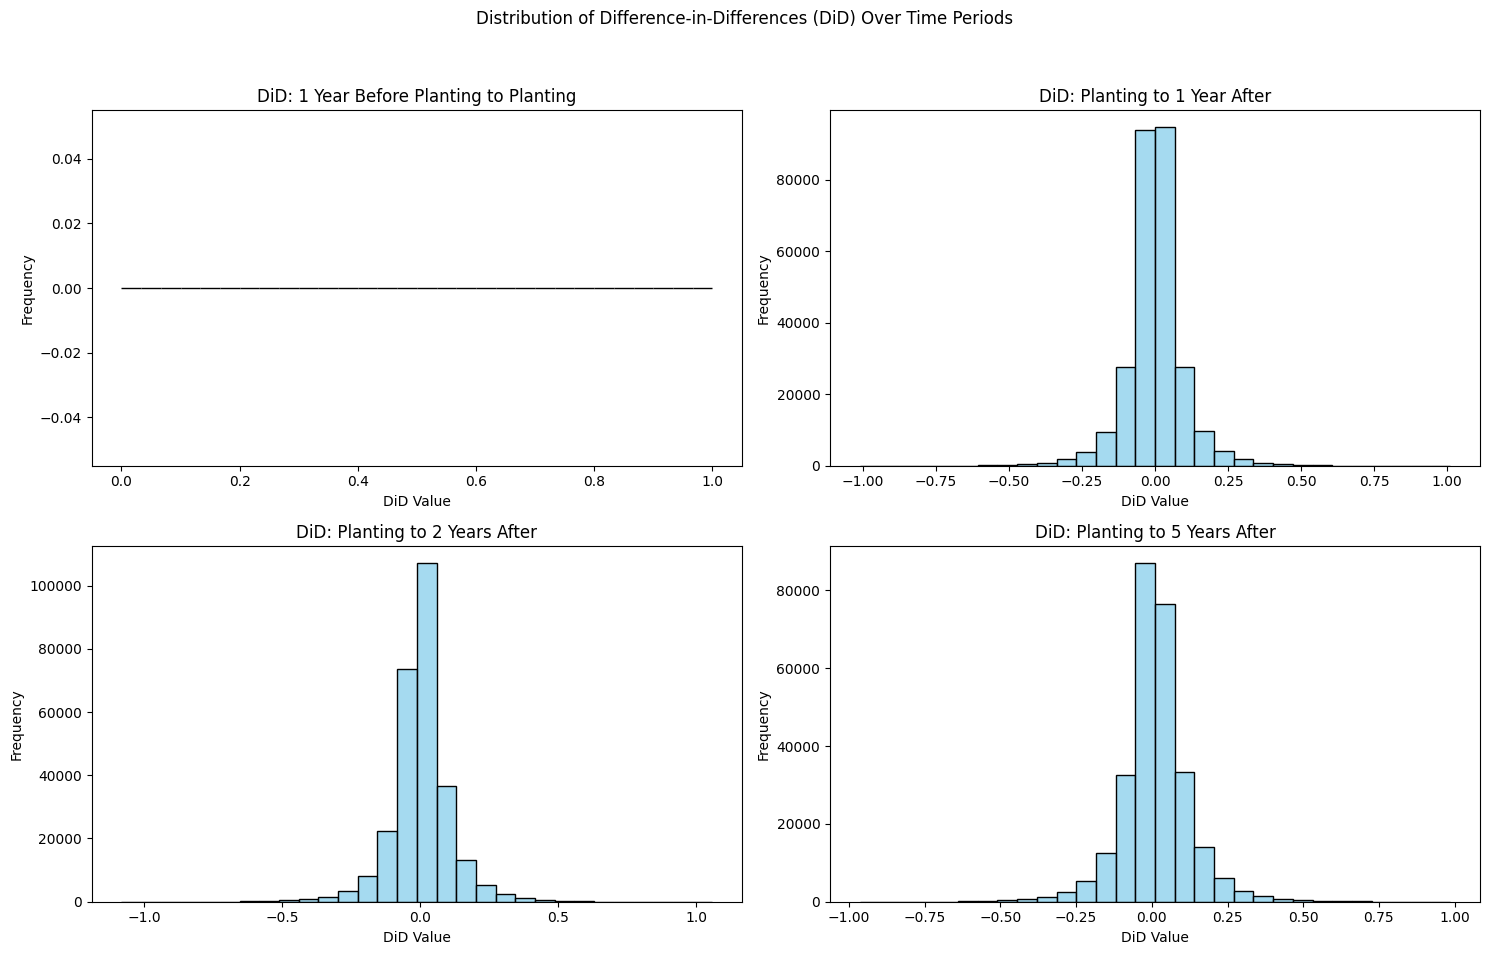

In [ ]:


# Reshaping DiD columns to long format for plotting
long_did_data = pd.melt(
    filtered_data,
    value_vars=[ "DiD_1YearAfter", "DiD_2YearsAfter", "DiD_5YearsAfter"],
    var_name="Time_Period",
    value_name="DiD_Value"
)

# Plotting histograms for each DiD distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Distribution of Difference-in-Differences (DiD) Over Time Periods")


time_period_titles = {
    "DiD_1YearBefore": "DiD: 1 Year Before Planting to Planting",
    "DiD_1YearAfter": "DiD: Planting to 1 Year After",
    "DiD_2YearsAfter": "DiD: Planting to 2 Years After",
    "DiD_5YearsAfter": "DiD: Planting to 5 Years After"
}


for ax, (time_period, title) in zip(axes.flat, time_period_titles.items()):
    sns.histplot(
        data=long_did_data[long_did_data["Time_Period"] == time_period],
        x="DiD_Value",
        bins=30,
        color='skyblue',
        edgecolor='black',
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('DiD Value')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:



# Defining the  bins and labels for 10 scores
bins = [-float('inf'),  100, 200, 300, 400, 500, 750, 1000,5000,10000, float('inf')]
scores = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]  # High score for smallest areas, low for largest


filtered_df['site_area_score'] = pd.cut(
    filtered_df['site_sqkm'],
    bins=bins,
    labels=scores
).astype(int)

filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 277629 entries, 3 to 772448
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   created_si                   277629 non-null  object 
 1   site_sqkm                    277629 non-null  float64
 2   trees_plan                   734 non-null     float64
 3   Intersec_1                   97911 non-null   object 
 4   Nested_in                    12236 non-null   object 
 5   built_area                   277629 non-null  float64
 6   total_road                   277629 non-null  float64
 7   loss_post_                   277621 non-null  float64
 8   loss_pos_1                   277621 non-null  float64
 9   planting_d                   277629 non-null  object 
 10  permanent                    277629 non-null  float64
 11  tree_cover_atplanting        277629 non-null  float64
 12  NDVI_Polygon_At_Planting     277629 non-null  float64
 13  DiD_

<ipython-input-20-cbd3353886e3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['site_area_score'] = pd.cut(


In [ ]:
def calculate_score(row):
    intersec_len = len(row['Intersec_1']) if isinstance(row['Intersec_1'], list) else 0
    nested_len = len(row['Nested_in']) if isinstance(row['Nested_in'], list) else 0

    if intersec_len == 0 and nested_len == 0:
        return 10

    elif intersec_len > 0 and nested_len == 0:
        if intersec_len in [2, 3]:
            return 6
        return 7

    elif intersec_len == 0 and nested_len > 0:
        if nested_len in [2, 3]:
            return 3
        return 4

    else:
        if intersec_len in [2, 3] or nested_len in [2, 3]:
            return 2
        return 1

filtered_df['Double_counting_indicator'] = filtered_df.apply(calculate_score, axis=1)


<ipython-input-21-250ba2b60e6e>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Double_counting_indicator'] = filtered_df.apply(calculate_score, axis=1)


In [ ]:

# # "Double_counting_indicator"
# filtered_df['Double_counting_indicator'] = np.where(
#     filtered_df['Intersec_1'].isnull() & filtered_df['Nested_in'].isnull(),
#     'High',
#     np.where(
#         filtered_df['Intersec_1'].notnull() & filtered_df['Nested_in'].isnull(),
#         'Moderate',
#         'Low'
#     )
# )

In [ ]:

filtered_df['loss_post_percent'] = (filtered_df['loss_post_'] / filtered_df['site_sqkm']) * 100
filtered_df['loss_pos_1_percent'] = (filtered_df['loss_pos_1'] / filtered_df['site_sqkm']) * 100

# #  "Permanence_Indicator"
# filtered_df['Permanence_Indicator'] = np.where(
#     (filtered_df['loss_post_percent'] > 20) | (filtered_df['loss_pos_1_percent'] > 20),
#     'Low',
#     np.where(
#         (filtered_df['loss_post_percent'] > 0) | (filtered_df['loss_pos_1_percent'] > 0),
#         'Moderate',
#         'High'
#     )
# )
def calculate_permanence_score(row):
    if row['loss_post_percent'] > 50 or row['loss_pos_1_percent'] > 50:
        return 1
    elif row['loss_post_percent'] > 40 or row['loss_pos_1_percent'] > 40:
        return 2
    elif row['loss_post_percent'] > 30 or row['loss_pos_1_percent'] > 30:
        return 3
    elif row['loss_post_percent'] > 20 or row['loss_pos_1_percent'] > 20:
        return 4
    elif row['loss_post_percent'] > 15 or row['loss_pos_1_percent'] > 15:
        return 5
    elif row['loss_post_percent'] > 10 or row['loss_pos_1_percent'] > 10:
        return 6
    elif row['loss_post_percent'] > 5 or row['loss_pos_1_percent'] > 5:
        return 7
    elif row['loss_post_percent'] > 2 or row['loss_pos_1_percent'] > 2:
        return 8
    elif row['loss_post_percent'] > 0 or row['loss_pos_1_percent'] > 0:
        return 9
    else:
        return 10

filtered_df['Permanence_Indicator'] = filtered_df.apply(calculate_permanence_score, axis=1)


<ipython-input-22-5d6929391396>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loss_post_percent'] = (filtered_df['loss_post_'] / filtered_df['site_sqkm']) * 100
<ipython-input-22-5d6929391396>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['loss_pos_1_percent'] = (filtered_df['loss_pos_1'] / filtered_df['site_sqkm']) * 100
<ipython-input-22-5d6929391396>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277629 entries, 3 to 772448
Data columns (total 24 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   created_si                   277629 non-null  object 
 1   site_sqkm                    277629 non-null  float64
 2   trees_plan                   734 non-null     float64
 3   Intersec_1                   97911 non-null   object 
 4   Nested_in                    12236 non-null   object 
 5   built_area                   277629 non-null  float64
 6   total_road                   277629 non-null  float64
 7   loss_post_                   277621 non-null  float64
 8   loss_pos_1                   277621 non-null  float64
 9   planting_d                   277629 non-null  object 
 10  permanent                    277629 non-null  float64
 11  tree_cover_atplanting        277629 non-null  float64
 12  NDVI_Polygon_At_Planting     277629 non-null  float64
 13  DiD_

Presence of vegetation at planting date

In [ ]:
filtered_df["tree_cover_atplanting"].describe()

,tree_cover_atplanting
count,277629.000000
mean,0.041412
std,5.934229
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2809.255734


In [ ]:

filtered_df['tree_cover_percent'] = (filtered_df['tree_cover_atplanting'] / filtered_df['site_sqkm']) * 100

def calculate_tree_cover_score(tree_cover_percent):
    """
    Assigns a score between 1 and 10 based on tree_cover_percent.
    Higher scores are for lower tree cover at planting date , prioritizing areas with less tree cover ata planting date.
    """
    if pd.isnull(tree_cover_percent):
        return np.nan
    elif tree_cover_percent <= 10:
        return 10  # Highest score for lowest tree cover at planting
    elif tree_cover_percent <= 20:
        return 9
    elif tree_cover_percent <= 30:
        return 8
    elif tree_cover_percent <= 40:
        return 7
    elif tree_cover_percent <= 50:
        return 6
    elif tree_cover_percent <= 60:
        return 5
    elif tree_cover_percent <= 70:
        return 4
    elif tree_cover_percent <= 80:
        return 3
    elif tree_cover_percent <= 90:
        return 2
    else:
        return 1  # Lowest score for highest tree cover at planting (>90%)


filtered_df['tree_cover_indicator'] = filtered_df['tree_cover_percent'].apply(calculate_tree_cover_score)


filtered_df.info()


<ipython-input-25-a509db1a66fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tree_cover_percent'] = (filtered_df['tree_cover_atplanting'] / filtered_df['site_sqkm']) * 100
<ipython-input-25-a509db1a66fa>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tree_cover_indicator'] = filtered_df['tree_cover_percent'].apply(calculate_tree_cover_score)


<class 'pandas.core.frame.DataFrame'>
Index: 277629 entries, 3 to 772448
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   created_si                   277629 non-null  object 
 1   site_sqkm                    277629 non-null  float64
 2   trees_plan                   734 non-null     float64
 3   Intersec_1                   97911 non-null   object 
 4   Nested_in                    12236 non-null   object 
 5   built_area                   277629 non-null  float64
 6   total_road                   277629 non-null  float64
 7   loss_post_                   277621 non-null  float64
 8   loss_pos_1                   277621 non-null  float64
 9   planting_d                   277629 non-null  object 
 10  permanent                    277629 non-null  float64
 11  tree_cover_atplanting        277629 non-null  float64
 12  NDVI_Polygon_At_Planting     277629 non-null  float64
 13  DiD_

Additionality indicator (Change in polygon are  using buffer are as   control)

In [ ]:

def calculate_score(row):

    score = 1

    # First condition: High impact
    if row['DiD_1YearAfter'] > 0.2 and row['DiD_2YearsAfter'] > 0.3 and row['DiD_5YearsAfter'] > 0.3:
        score = 10
    # Second condition: Moderate to High impact
    elif row['DiD_1YearAfter'] > 0.1 and row['DiD_2YearsAfter'] > 0.2 and row['DiD_5YearsAfter'] > 0.2:
        score = 8
    # Third condition: Moderate impact
    elif row['DiD_1YearAfter'] > 0.05 and row['DiD_2YearsAfter'] > 0.1 and row['DiD_5YearsAfter'] > 0.1:
        score = 6
    # Fourth condition: Low impact
    elif row['DiD_1YearAfter'] > 0 and row['DiD_2YearsAfter'] > 0 and row['DiD_5YearsAfter'] > 0:
        score = 4
    # No significant change
    elif row['DiD_1YearAfter'] <= 0 or row['DiD_2YearsAfter'] <= 0 or row['DiD_5YearsAfter'] <= 0:
        score = 2  # Low score for no or negative change

    return score


filtered_df['additionally_indicator'] = filtered_df.apply(calculate_score, axis=1)


filtered_df.info()



<class 'pandas.core.frame.DataFrame'>
Index: 277629 entries, 3 to 772448
Data columns (total 27 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   created_si                   277629 non-null  object 
 1   site_sqkm                    277629 non-null  float64
 2   trees_plan                   734 non-null     float64
 3   Intersec_1                   97911 non-null   object 
 4   Nested_in                    12236 non-null   object 
 5   built_area                   277629 non-null  float64
 6   total_road                   277629 non-null  float64
 7   loss_post_                   277621 non-null  float64
 8   loss_pos_1                   277621 non-null  float64
 9   planting_d                   277629 non-null  object 
 10  permanent                    277629 non-null  float64
 11  tree_cover_atplanting        277629 non-null  float64
 12  NDVI_Polygon_At_Planting     277629 non-null  float64
 13  DiD_

<ipython-input-26-5c2416f848d1>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['additionally_indicator'] = filtered_df.apply(calculate_score, axis=1)


In [ ]:

filtered_df['permanent_percent'] = (filtered_df['permanent'] / filtered_df['site_sqkm']) * 100


filtered_df['water_source_score'] = np.select(
    [
        filtered_df['permanent_percent'] > 20,
        (filtered_df['permanent_percent'] > 10) & (filtered_df['permanent_percent'] <= 20),
        (filtered_df['permanent_percent'] > 5) & (filtered_df['permanent_percent'] <= 10),
        (filtered_df['permanent_percent'] > 0) & (filtered_df['permanent_percent'] <= 5),
        filtered_df['permanent_percent'] == 0
    ],
    [
        1,
        3,
        5,
        7,
        10
    ],
    default=0
)
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277629 entries, 3 to 772448
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   created_si                   277629 non-null  object 
 1   site_sqkm                    277629 non-null  float64
 2   trees_plan                   734 non-null     float64
 3   Intersec_1                   97911 non-null   object 
 4   Nested_in                    12236 non-null   object 
 5   built_area                   277629 non-null  float64
 6   total_road                   277629 non-null  float64
 7   loss_post_                   277621 non-null  float64
 8   loss_pos_1                   277621 non-null  float64
 9   planting_d                   277629 non-null  object 
 10  permanent                    277629 non-null  float64
 11  tree_cover_atplanting        277629 non-null  float64
 12  NDVI_Polygon_At_Planting     277629 non-null  float64
 13  DiD_

<ipython-input-27-3c051f8f8c4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['permanent_percent'] = (filtered_df['permanent'] / filtered_df['site_sqkm']) * 100
<ipython-input-27-3c051f8f8c4a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['water_source_score'] = np.select(


In [ ]:

road_width_km = 0.01

# Calculating the road area and total coverage
filtered_df['road_area'] = filtered_df['total_road'] * road_width_km
filtered_df['total_coverage'] = filtered_df['built_area'] + filtered_df['road_area']
filtered_df['coverage_percent'] = (filtered_df['total_coverage'] / filtered_df['site_sqkm']) * 100

filtered_df['Coverage_quality_score'] = np.select(
    [
        (filtered_df['coverage_percent'] == 0),                         # High quality (max score)
        (filtered_df['coverage_percent'] > 0) & (filtered_df['coverage_percent'] <= 1),   # 1%-10%
        (filtered_df['coverage_percent'] > 1) & (filtered_df['coverage_percent'] <= 2),
        (filtered_df['coverage_percent'] > 2) & (filtered_df['coverage_percent'] <= 3),
        (filtered_df['coverage_percent'] > 3) & (filtered_df['coverage_percent'] <= 4),
        (filtered_df['coverage_percent'] > 4) & (filtered_df['coverage_percent'] <= 5),
        (filtered_df['coverage_percent'] > 5) & (filtered_df['coverage_percent'] <= 7),
        (filtered_df['coverage_percent'] > 7) & (filtered_df['coverage_percent'] <= 10),
        (filtered_df['coverage_percent'] > 10) & (filtered_df['coverage_percent'] <= 20),
        (filtered_df['coverage_percent'] > 20)
    ],
    [10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
    default=1
)
filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 277629 entries, 3 to 772448
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   created_si                   277629 non-null  object 
 1   site_sqkm                    277629 non-null  float64
 2   trees_plan                   734 non-null     float64
 3   Intersec_1                   97911 non-null   object 
 4   Nested_in                    12236 non-null   object 
 5   built_area                   277629 non-null  float64
 6   total_road                   277629 non-null  float64
 7   loss_post_                   277621 non-null  float64
 8   loss_pos_1                   277621 non-null  float64
 9   planting_d                   277629 non-null  object 
 10  permanent                    277629 non-null  float64
 11  tree_cover_atplanting        277629 non-null  float64
 12  NDVI_Polygon_At_Planting     277629 non-null  float64
 13  DiD_

<ipython-input-28-0016a648a027>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['road_area'] = filtered_df['total_road'] * road_width_km
<ipython-input-28-0016a648a027>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['total_coverage'] = filtered_df['built_area'] + filtered_df['road_area']
<ipython-input-28-0016a648a027>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277629 entries, 3 to 772448
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   created_si                   277629 non-null  object 
 1   site_sqkm                    277629 non-null  float64
 2   trees_plan                   734 non-null     float64
 3   Intersec_1                   97911 non-null   object 
 4   Nested_in                    12236 non-null   object 
 5   built_area                   277629 non-null  float64
 6   total_road                   277629 non-null  float64
 7   loss_post_                   277621 non-null  float64
 8   loss_pos_1                   277621 non-null  float64
 9   planting_d                   277629 non-null  object 
 10  permanent                    277629 non-null  float64
 11  tree_cover_atplanting        277629 non-null  float64
 12  NDVI_Polygon_At_Planting     277629 non-null  float64
 13  DiD_

In [ ]:

filtered_df['cropland_ratio'] = filtered_df['cropland g'] / filtered_df['site_sqkm']


bins = [-float('inf'), 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, float('inf')]
scores = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

filtered_df['landcover_change_score'] = pd.cut(
    filtered_df['cropland_ratio'],
    bins=bins,
    labels=scores
).astype(int)

filtered_df.head()


<ipython-input-30-9d4ccd78c7b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['cropland_ratio'] = filtered_df['cropland g'] / filtered_df['site_sqkm']
<ipython-input-30-9d4ccd78c7b2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['landcover_change_score'] = pd.cut(


,created_si,site_sqkm,trees_plan,Intersec_1,Nested_in,built_area,total_road,loss_post_,loss_pos_1,planting_d,...,tree_cover_indicator,additionally_indicator,permanent_percent,water_source_score,road_area,total_coverage,coverage_percent,Coverage_quality_score,cropland_ratio,landcover_change_score
3,reforest_site_1000,0.463981,86.0,NaN,NaN,0.000208,0.0,0.0,0.0,2019-02-06 19:03:19+00:00,...,7,2,0.0,10,0.0,0.000208,0.044848,9,0.0,10
12,reforest_site_100007,0.064217,NaN,NaN,NaN,0.000088,0.0,0.0,0.0,2015-01-01,...,3,2,0.0,10,0.0,0.000088,0.137500,9,0.0,10
114,reforest_site_1001,2.191749,830.0,NaN,NaN,0.000539,0.0,0.0,0.0,2019-02-06 19:17:00+00:00,...,2,2,0.0,10,0.0,0.000539,0.024578,9,0.0,10
225,reforest_site_1002,1.513540,304.0,reforest_site_1015,NaN,0.000390,0.0,0.0,0.0,2019-02-06 19:41:41+00:00,...,4,2,0.0,10,0.0,0.000390,0.025741,9,0.0,10
336,reforest_site_1003,1.320046,55.0,NaN,NaN,0.001486,0.0,0.0,0.0,2019-02-06 21:12:32+00:00,...,7,2,0.0,10,0.0,0.001486,0.112582,9,0.0,10


In [ ]:
# Selecting indicator columns
columns_of_interest = ['created_si', 'site_area_score','Double_counting_indicator','Permanence_Indicator','tree_cover_indicator','additionally_indicator','water_source_score','Coverage_quality_score','Feasibility_Score',"landcover_change_score"
                       ]
filtered_ind = filtered_df[columns_of_interest]
filtered_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277629 entries, 3 to 772448
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   created_si                 277629 non-null  object
 1   site_area_score            277629 non-null  int64 
 2   Double_counting_indicator  277629 non-null  int64 
 3   Permanence_Indicator       277629 non-null  int64 
 4   tree_cover_indicator       277629 non-null  int64 
 5   additionally_indicator     277629 non-null  int64 
 6   water_source_score         277629 non-null  int64 
 7   Coverage_quality_score     277629 non-null  int64 
 8   Feasibility_Score          277629 non-null  int64 
 9   landcover_change_score     277629 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 23.3+ MB


In [ ]:

# Create a Digraph object with Left-to-Right layout
dot = Digraph(format='png', engine='dot')
dot.attr(rankdir='LR')  # Set the direction of the graph to Left-to-Right


dot.node('Start', 'Input Data', shape='ellipse', style='filled', color='lightblue')


dot.node('site_area_score', 'Site Area Score', shape='box', style='rounded,filled', color='lightgreen')
dot.node('double_count', 'Intersecting and Nesting polygons', shape='box', style='rounded,filled', color='lightgreen')
dot.node('permanence', 'Loss After Planting', shape='box', style='rounded,filled', color='lightgreen')
dot.node('tree_cover', 'Tree Cover_atplanting ', shape='box', style='rounded,filled', color='lightgreen')
dot.node('additionally', 'Change in polygon area compared to buffer', shape='box', style='rounded,filled', color='lightgreen')
dot.node('water_source', 'Water Source presence', shape='box', style='rounded,filled', color='lightgreen')
dot.node('coverage_quality', 'Infrastructure Presesnce', shape='box', style='rounded,filled', color='lightgreen')
dot.node('feasibility', 'Density planted per hectare', shape='box', style='rounded,filled', color='lightgreen')
dot.node('landcover_change', 'Landcover Change(Tree area changed to cropland)', shape='box', style='rounded,filled', color='lightgreen')

# Adding processing and output nodes
dot.node('Processing', 'Combine Indicators & Scores', shape='diamond', style='filled', color='gold')
dot.node('Output', 'Quality Framework', shape='ellipse', style='filled', color='lightcoral')

# Adding the edges to connect nodes
dot.edge('Start', 'site_area_score')
dot.edge('Start', 'double_count')
dot.edge('Start', 'permanence')
dot.edge('Start', 'tree_cover')
dot.edge('Start', 'additionally')
dot.edge('Start', 'water_source')
dot.edge('Start', 'coverage_quality')
dot.edge('Start', 'feasibility')
dot.edge('Start', 'landcover_change')

# Connecting  all the individual scores to the processing node
dot.edge('site_area_score', 'Processing')
dot.edge('double_count', 'Processing')
dot.edge('permanence', 'Processing')
dot.edge('tree_cover', 'Processing')
dot.edge('additionally', 'Processing')
dot.edge('water_source', 'Processing')
dot.edge('coverage_quality', 'Processing')
dot.edge('feasibility', 'Processing')
dot.edge('landcover_change', 'Processing')

# Connecting the processing node to the final output
dot.edge('Processing', 'Output')


dot.render('New_quality_framework_flowchart', view=True)


'New_quality_framework_flowchart.png'

In [ ]:

score_columns = [
    'site_area_score', 'Double_counting_indicator', 'Permanence_Indicator',
    'tree_cover_indicator', 'additionally_indicator', 'water_source_score',
    'Coverage_quality_score', 'Feasibility_Score', 'landcover_change_score'
]

filtered_df['quality_score'] = filtered_df[score_columns].mean(axis=1)


filtered_df['quality_score'] = filtered_df['quality_score'].round(2)

filtered_df.head()


<ipython-input-62-7982130fd27c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['quality_score'] = filtered_df[score_columns].mean(axis=1)
<ipython-input-62-7982130fd27c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['quality_score'] = filtered_df['quality_score'].round(2)


,created_si,site_sqkm,trees_plan,Intersec_1,Nested_in,built_area,total_road,loss_post_,loss_pos_1,planting_d,...,additionally_indicator,permanent_percent,water_source_score,road_area,total_coverage,coverage_percent,Coverage_quality_score,cropland_ratio,landcover_change_score,quality_score
3,reforest_site_1000,0.463981,86.0,NaN,NaN,0.000208,0.0,0.0,0.0,2019-02-06 19:03:19+00:00,...,2,0.0,10,0.0,0.000208,0.044848,9,0.0,10,8.67
12,reforest_site_100007,0.064217,NaN,NaN,NaN,0.000088,0.0,0.0,0.0,2015-01-01,...,2,0.0,10,0.0,0.000088,0.137500,9,0.0,10,7.22
114,reforest_site_1001,2.191749,830.0,NaN,NaN,0.000539,0.0,0.0,0.0,2019-02-06 19:17:00+00:00,...,2,0.0,10,0.0,0.000539,0.024578,9,0.0,10,8.11
225,reforest_site_1002,1.513540,304.0,reforest_site_1015,NaN,0.000390,0.0,0.0,0.0,2019-02-06 19:41:41+00:00,...,2,0.0,10,0.0,0.000390,0.025741,9,0.0,10,8.33
336,reforest_site_1003,1.320046,55.0,NaN,NaN,0.001486,0.0,0.0,0.0,2019-02-06 21:12:32+00:00,...,2,0.0,10,0.0,0.001486,0.112582,9,0.0,10,8.67


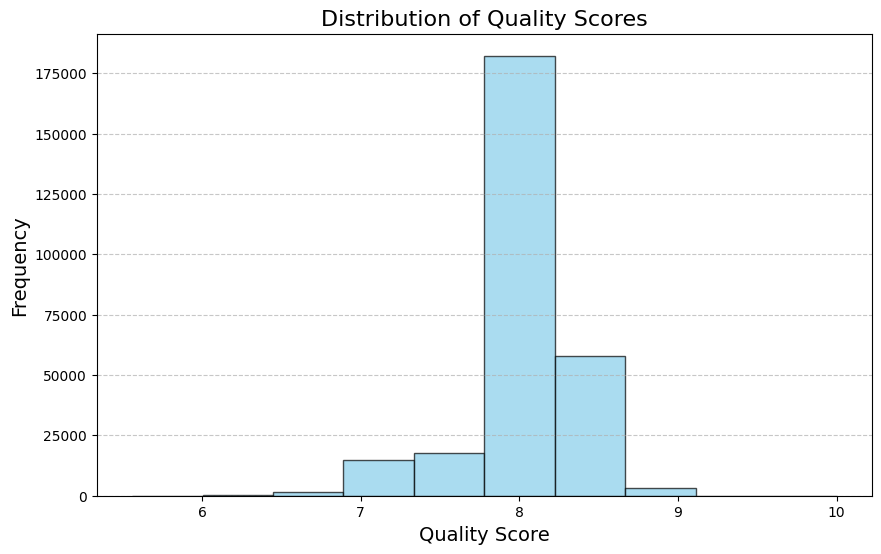

In [ ]:

plt.figure(figsize=(10, 6))
plt.hist(filtered_df['quality_score'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)


plt.title('Distribution of Quality Scores', fontsize=16)
plt.xlabel('Quality Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
